In [1]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
import tensorflow as tf
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# 資料路徑
DATASET_PATH  = 'sample'

# 影像大小
IMAGE_SIZE = (240, 240)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 40

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-EfficientNetB1-final.h5'


In [2]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 Efficient 為基礎來建立模型，
# 捨棄 Efficient 頂層的 fully connected layers
net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())


Found 2000 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs
83697664/83683744 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1

In [3]:
# 訓練模型
history = net_final.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/20
250/250 [==============================] - 34s 114ms/step - loss: 0.4413 - accuracy: 0.7830 - val_loss: 0.0934 - val_accuracy: 0.9735
Epoch 2/20
250/250 [==============================] - 28s 113ms/step - loss: 0.2280 - accuracy: 0.9075 - val_loss: 0.0638 - val_accuracy: 0.9836
Epoch 3/20
250/250 [==============================] - 28s 112ms/step - loss: 0.1683 - accuracy: 0.9330 - val_loss: 0.0509 - val_accuracy: 0.9823
Epoch 4/20
250/250 [==============================] - 28s 114ms/step - loss: 0.1493 - accuracy: 0.9440 - val_loss: 0.0442 - val_accuracy: 0.9874
Epoch 5/20
250/250 [==============================] - 28s 113ms/step - loss: 0.1399 - accuracy: 0.9450 - val_loss: 0.0433 - val_accuracy: 0.9874
Epoch 6/20
250/250 [==============================] - 28s 113ms/step - loss: 0.1096 - accuracy: 0.9565 - val_loss: 0.0397 - val_accuracy: 0.9886
Epoch 7/20
250/250 [==============================] - 28s 112ms/step - loss: 0.1074 - accuracy: 0.9565 - val_loss: 0.0415 - val_ac

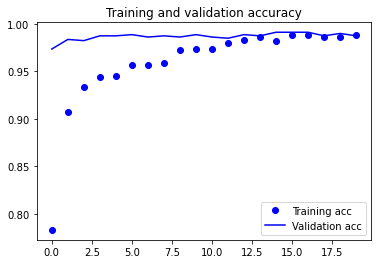

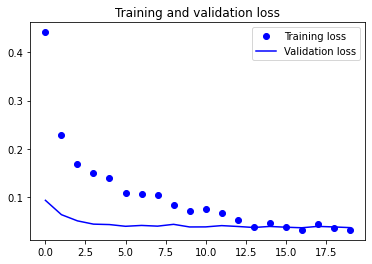

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()